Debes crear las siguientes funciones para los endpoints que se consumirán en la API, recuerden que deben tener un decorador por cada una (@app.get(‘/’)).

Identificando las columnas necesarias para las funciones:

def PlayTimeGenre( genero : str ): Debe devolver año con mas horas jugadas para dicho género.
Ejemplo de retorno: {"Año de lanzamiento con más horas jugadas para Género X" : 2013}

- games.genres
- games.release_date (solo el año)
- games.id
- items.item_id
- items.playtime_forever

def UserForGenre( genero : str ): Debe devolver el usuario que acumula más horas jugadas para el género dado y una lista de la acumulación de horas jugadas por año.
Ejemplo de retorno: {"Usuario con más horas jugadas para Género X" : us213ndjss09sdf, "Horas jugadas":[{Año: 2013, Horas: 203}, {Año: 2012, Horas: 100}, {Año: 2011, Horas: 23}]}

- games.genres
- games.id
- items.item_id
- items.user_id
- items.playtime_forever
- reviews.posted (solo el año)

def UsersRecommend( año : int ): Devuelve el top 3 de juegos MÁS recomendados por usuarios para el año dado. (reviews.recommend = True y comentarios positivos/neutrales)
Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]

- reviews.posted (solo el año)
- reviews.recommend
- reviews.review
- reviews.item_id
- games.id
- games.app_name

def UsersNotRecommend( año : int ): Devuelve el top 3 de juegos MENOS recomendados por usuarios para el año dado. (reviews.recommend = False y comentarios negativos)
Ejemplo de retorno: [{"Puesto 1" : X}, {"Puesto 2" : Y},{"Puesto 3" : Z}]

- reviews.posted (solo el año)
- reviews.recommend
- reviews.review
- reviews.item_id
- games.id
- games.app_name

def sentiment_analysis( año : int ): Según el año de lanzamiento, se devuelve una lista con la cantidad de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento.
Ejemplo de retorno: {Negative = 182, Neutral = 120, Positive = 278}

- games.release_date (solo el año)
- games.id
- reviews.item_id
- reviews.recommend

 ---------------------------------------------------------------------------------------------------

EXTRACCION

Como paso inicial se decomprimieron los archivos comprimidos .gz usando Winrar

output_steam_games.json

Importamos las librerias a utilizar

In [1]:
import pandas as pd
import numpy as np
import json
import ast
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from scipy import stats
import seaborn as sns
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

Para extraer la data del archivo, utilizo la libreria json, recorro linea por linea y finalmente la transformo en un DF

Ejecuto la propiedad info para ver las columnas y el total de registros

In [3]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


Ejecuto la propiedad head para ver las primeras fila del DF

In [4]:
df_games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como podemos notar en las primeras columnas se observan muchos nulos, por lo cual ejecutare el DF 

In [5]:
df_games

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120440,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,False,773640,"Nikita ""Ghost_RUS"""
120441,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530,Sacada
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660,Laush Dmitriy Sergeevich
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870,"xropi,stev3ns"


australian_user_reviews.json

In [6]:
data = []

# Abre el archivo JSON en modo lectura
with open("australian_user_reviews.json", "r", encoding="utf-8") as archivo:
    for linea in archivo:
        # Lee cada línea del archivo como una cadena JSON
        linea_json = ast.literal_eval(linea.strip())
        
        # Agrega el diccionario JSON a la lista
        data.append(linea_json)

# Crea el DataFrame directamente desde la lista de diccionarios
df_reviews = pd.DataFrame(data)

In [7]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25799 entries, 0 to 25798
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   user_id   25799 non-null  object
 1   user_url  25799 non-null  object
 2   reviews   25799 non-null  object
dtypes: object(3)
memory usage: 604.8+ KB


In [8]:
df_reviews.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


In [9]:
type(df_reviews["reviews"])

pandas.core.series.Series

al ser la columna reviews una serie de pandas, procedemos a aplanarla 


In [10]:
df_reviews_aplanado = df_reviews.explode('reviews')


In [11]:
df_reviews_aplanado.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted November 5, 20..."
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted July 15, 2011...."
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'funny': '', 'posted': 'Posted April 21, 2011..."
1,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted June 24, 2014...."
1,js41637,http://steamcommunity.com/id/js41637,"{'funny': '', 'posted': 'Posted September 8, 2..."


In [12]:
type(df_reviews_aplanado["reviews"])

pandas.core.series.Series

Observamos que luego de aplanar al columna reviews ya tenemos el formato correcto para poder desanidarla

In [13]:
# desanidamos la columna reviews
df_reviews_desanidado = pd.json_normalize(df_reviews_aplanado['reviews'].dropna())

# reindezamos para poder concatenar los DF
df_reviews_desanidado.reset_index(inplace=True)
df_reviews_aplanado.reset_index(inplace=True)

# concatenamos y eliminamos la columna anidada original
df_reviews = pd.concat([df_reviews_aplanado,df_reviews_desanidado], axis=1)
df_reviews = df_reviews.drop(columns = ['reviews'])


In [14]:
df_reviews.head()

,index,user_id,user_url,index,funny,posted,last_edited,item_id,helpful,recommend,review
0,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,0.0,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1.0,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2.0,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,1,js41637,http://steamcommunity.com/id/js41637,3.0,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,1,js41637,http://steamcommunity.com/id/js41637,4.0,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


australian_users_items.json

In [15]:
data = []

# Abre el archivo JSON en modo lectura
with open("australian_users_items.json", "r", encoding="utf-8") as archivo:
    for linea in archivo:
        # Lee cada línea del archivo como una cadena JSON
        linea_json = ast.literal_eval(linea.strip())
        
        # Agrega el diccionario JSON a la lista
        data.append(linea_json)

# Crea el DataFrame directamente desde la lista de diccionarios
df_items = pd.DataFrame(data)

In [16]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88310 entries, 0 to 88309
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   user_id      88310 non-null  object
 1   items_count  88310 non-null  int64 
 2   steam_id     88310 non-null  object
 3   user_url     88310 non-null  object
 4   items        88310 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.4+ MB


In [17]:
df_items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


In [18]:
type(df_items["items"])

pandas.core.series.Series

viendo la columna items identificamos nuevamente una columna que contiene un serie de pandas y procedemos a aplanarla

In [19]:
df_items_aplanado = df_items.explode('items')

In [20]:
df_items_aplanado.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '10', 'item_name': 'Counter-Strike..."
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '20', 'item_name': 'Team Fortress ..."
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '30', 'item_name': 'Day of Defeat'..."
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '40', 'item_name': 'Deathmatch Cla..."
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"{'item_id': '50', 'item_name': 'Half-Life: Opp..."


In [21]:
type(df_items["items"])

pandas.core.series.Series

desanidamos la columna items

In [22]:
# desanidamos la columna reviews
df_items_desanidado = pd.json_normalize(df_items_aplanado['items'].dropna())

# reindezamos para poder concatenar los DF
df_items_desanidado.reset_index(inplace=True)
df_items_aplanado.reset_index(inplace=True)

# concatenamos y eliminamos la columna anidada original
df_items = pd.concat([df_items_aplanado,df_items_desanidado], axis=1)
df_items = df_items.drop(columns = ['items'])


In [23]:
df_items.head()

,index,user_id,items_count,steam_id,user_url,index,item_id,item_name,playtime_forever,playtime_2weeks
0,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,0.0,10,Counter-Strike,6.0,0.0
1,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,1.0,20,Team Fortress Classic,0.0,0.0
2,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,2.0,30,Day of Defeat,7.0,0.0
3,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,3.0,40,Deathmatch Classic,0.0,0.0
4,0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,4.0,50,Half-Life: Opposing Force,0.0,0.0


EDA

Analizamos el contenido de df_games

In [24]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


In [25]:
df_games.describe(include="all")

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
count,24083,28852,32133,30085,32135,30068,31972,32133,31465,30758.00,32135,32133,28836
unique,8239,883,32094,30054,32135,3582,15395,32132,4649,162.00,2,32132,10992
top,Ubisoft,[Action],Soundtrack,Soundtrack,http://store.steampowered.com/app/761140/Lost_...,2012-10-16,"[Casual, Simulation]",http://steamcommunity.com/app/612880/reviews/?...,[Single-player],4.99,False,612880,Ubisoft - San Francisco
freq,385,1880,3,3,1,100,1292,2,2794,4278.00,30188,2,1259


Orientando el analisis en base a las funciones, podemos observar que tenemos 28852 registros para genres de los cuales 883 representan valores unicos

Necesitamos extraer solo el año de release_date

In [26]:
df_games["release_date"].unique()

array([nan, '2018-01-04', '2017-07-24', ..., '2016-11-19', 'January 2018',
       '2018-10-01'], dtype=object)

genero una columna temporal para identicar los valores que no coinciden con el formato yy-mm-dd

In [27]:
df_games["tmp_fechas"] = df_games["release_date"].str.match("^\d{4}-\d{2}-\d{2}$")

In [28]:
df_games.loc[:,["release_date","tmp_fechas"]]

,release_date,tmp_fechas
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
120440,2018-01-04,True
120441,2018-01-04,True
120442,2018-01-04,True
120443,2017-09-02,True


In [29]:
df_games.query("tmp_fechas == False").loc[:,["release_date","tmp_fechas"]]

,release_date,tmp_fechas
88320,Soon..,False
88353,2017,False
88354,Beta测试已开启,False
88560,Jun 2009,False
88816,Oct 2010,False
...,...,...
120392,15.01.2018,False
120393,"Q1, 2018",False
120397,Coming Soon,False
120407,2016,False


Al no ser una cantidad representativa, procedemos a cambiar esos valor por vacios o nulos

In [30]:
df_games.loc[df_games["tmp_fechas"] == False, "release_date"] = ""

In [31]:
df_games = df_games.drop("tmp_fechas", axis=1)

In [32]:
df_games["release_date"] = pd.to_datetime(df_games["release_date"])

finalmente generamos una nueva columna solo con el año de lanzamiento y eliminamos release_date

In [33]:
df_games["release_year"]=df_games["release_date"].dt.strftime("%Y")
df_games = df_games.drop("release_date", axis=1)

Busco los generos unicos dentro de genres

In [34]:
df_generos = df_games["genres"]

In [35]:
df_generos = df_generos.explode() 

In [36]:
df_generos.dropna(inplace=True)

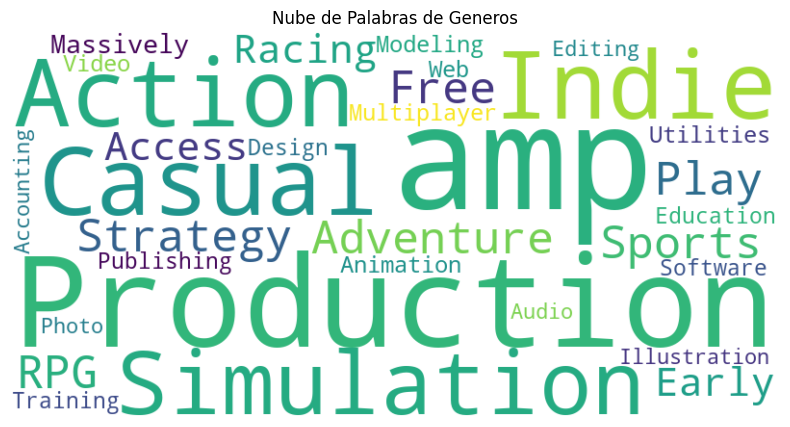

In [37]:
titulos = df_generos.unique()

# Combina los títulos en una sola cadena
texto = ' '.join(titulos)

# Crea la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(texto)

# Muestra la nube de palabras en una figura de matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de Generos')
plt.show()

podemos ver que existen 23 generos unicos

In [38]:
df_games["genres"].value_counts().head(20)

genres
[Action]                      1880
[Action, Indie]               1650
[Simulation]                  1396
[Casual, Simulation]          1359
[Action, Adventure, Indie]    1082
[Strategy]                    1056
[Adventure, Indie]            1007
[Indie, RPG, Strategy]         945
[Casual, Indie]                899
[Action, Adventure]            762
[Action, Casual, Indie]        670
[Indie]                        662
[Adventure, Casual, Indie]     592
[Adventure]                    486
[Adventure, Casual]            431
[Indie, Strategy]              417
[RPG]                          410
[Casual]                       406
[Adventure, Indie, RPG]        360
[Casual, Indie, Strategy]      341
Name: count, dtype: int64

In [39]:
grupo01 = df_games.groupby(['release_year'])['genres'].count().reset_index()

In [40]:
grupo01.sort_values(by="genres", ascending=False).head(20)

,release_year,genres
39,2017,9208
38,2016,6691
37,2015,4794
36,2014,2728
35,2013,1477
34,2012,1138
33,2011,541
32,2010,393
31,2009,316
30,2008,194


podemos notar ue los años 2017, 2016, 2015 y 2014 son los años con mayor cantidad de generos lanzados

usaremos los 10 primeros puesto en cantidad de generos para realizar un grafico

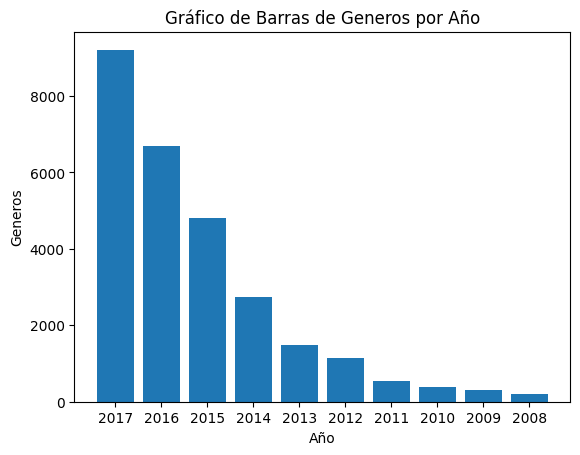

In [41]:
# Reordenar el DataFrame de mayor a menor en función de la columna 
df_grafico01 = grupo01.sort_values(by="genres", ascending=False).head(10)

# Crear un gráfico de barras
plt.bar(df_grafico01["release_year"], df_grafico01["genres"])

# Personalizar el gráfico
plt.xlabel('Año')
plt.ylabel('Generos')
plt.title('Gráfico de Barras de Generos por Año')

# Mostrar el gráfico
plt.show()

identificando outliers y agrupando datos

debido a la cantidad de años, decidi considerar solo los ultimos 20 que son a mi consideracion debido al avance tecnologico donde se empezo a desarrollar mejor la industria de videojuegos

In [42]:
df_grafico02 = grupo01.sort_values(by="release_year", ascending=False).head(20)

In [43]:
df_grafico02

,release_year,genres
42,2021,1
41,2019,3
40,2018,92
39,2017,9208
38,2016,6691
37,2015,4794
36,2014,2728
35,2013,1477
34,2012,1138
33,2011,541


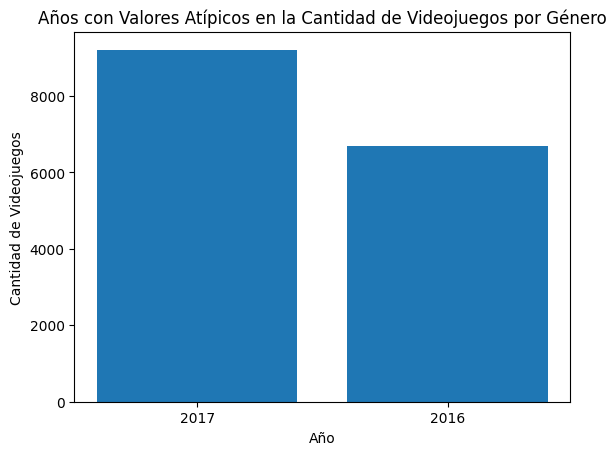

In [44]:

# Calcular el z-score para identificar años con valores atípicos
z_scores = stats.zscore(df_grafico02['genres'])

# Umbral para identificar años con valores atípicos
umbral = 2  # Puedes ajustar este valor según tus necesidades

# Filtrar años con valores atípicos
outliers = df_grafico02[abs(z_scores) > umbral]

# Crear un gráfico de barras para los años con valores atípicos
plt.bar(outliers['release_year'], outliers['genres'])
plt.xlabel('Año')
plt.ylabel('Cantidad de Videojuegos')
plt.title('Años con Valores Atípicos en la Cantidad de Videojuegos por Género')
plt.show()

pese a ser considerados valor atipicos los generos existentes en 2017 y 2016 considero no retirarlos pues podrian alterar el sentido de mis funciones solicitadas

ahora analizamos la cantidad de juegos por año de lanzamiento

In [45]:
df_games["app_name"].unique().tolist()

[nan,
 'Lost Summoner Kitty',
 'Ironbound',
 'Real Pool 3D - Poolians',
 '弹炸人2222',
 'Log Challenge',
 'Battle Royale Trainer',
 'SNOW - All Access Basic Pass',
 'SNOW - All Access Pro Pass',
 'SNOW - All Access Legend Pass',
 'Race',
 'Uncanny Islands',
 'Icarus Six Sixty Six',
 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition',
 'Beach Rules',
 'Planetarium 2 - Zen Odyssey',
 'The first thrust of God',
 'SNOW - Starter Pack',
 'The first thrust of God - All Aircrafts',
 'SNOW - Lifetime Pack',
 'After Life VR',
 'Kitty Hawk',
 'The Warrior Of Treasures',
 'Mortars VR',
 'RC Plane 3 - Canyon Scenario',
 'RC Plane 3 - F-53B',
 'DinoBlaster',
 'Robotpencil Presents: Understanding 3D for Concept',
 'Carmageddon Max Pack',
 'Half-Life',
 'Fallen Mage',
 "Don't Get Hit In The Face",
 'Lost Cities',
 'Twisted Enhanced Edition',
 'Vaporwave Simulator',
 'Tactics Forever',
 'Christmas Santa Troubles',
 'Kingdom Watcher',
 'Underdone - Soundtrack',
 'Bitcoin Clic

In [46]:
grupo02 = df_games.groupby(['release_year'])['app_name'].count().reset_index()

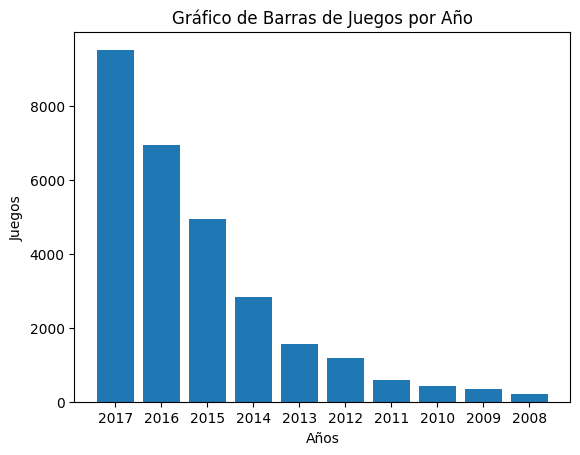

In [47]:
# Reordenar el DataFrame de mayor a menor en función de la columna 
df_grafico01 = grupo02.sort_values(by="app_name", ascending=False).head(10)

# Crear un gráfico de barras
plt.bar(df_grafico01["release_year"], df_grafico01["app_name"])

# Personalizar el gráfico
plt.xlabel('Años')
plt.ylabel('Juegos')
plt.title('Gráfico de Barras de Juegos por Año')

# Mostrar el gráfico
plt.show()

podemos notar claramente una relacion entre la cantidad de juegos lanzados y los generos en los mismos años

In [48]:
df_grafico02 = grupo02.sort_values(by="app_name", ascending=False).head(20)

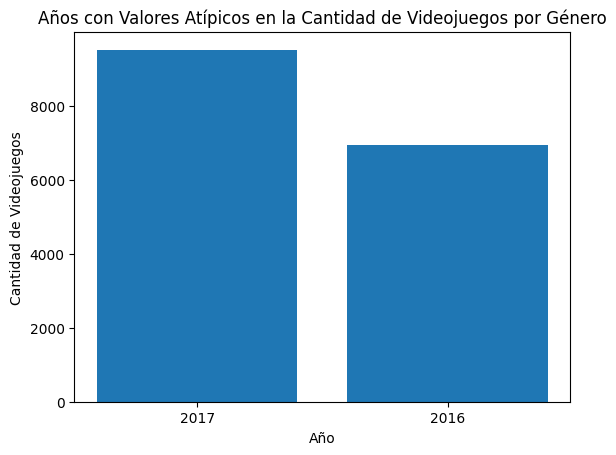

In [49]:
# Calcular el z-score para identificar años con valores atípicos
z_scores = stats.zscore(df_grafico02['app_name'])

# Umbral para identificar años con valores atípicos
umbral = 2  # Puedes ajustar este valor según tus necesidades

# Filtrar años con valores atípicos
outliers = df_grafico02[abs(z_scores) > umbral]

# Crear un gráfico de barras para los años con valores atípicos
plt.bar(outliers['release_year'], outliers['app_name'])
plt.xlabel('Año')
plt.ylabel('Cantidad de Videojuegos')
plt.title('Años con Valores Atípicos en la Cantidad de Videojuegos por Género')
plt.show()

generamos un heatmap para detectar valores nulos que luego seran borrados o remplazados, luego de identificar las columnas necesarias a utilizar

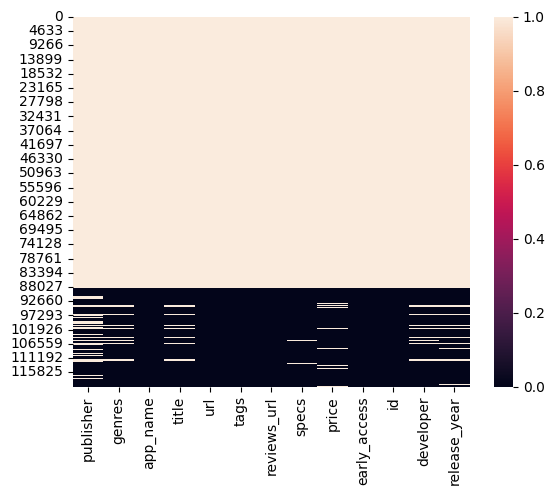

In [50]:
sns.heatmap(df_games.isnull())
plt.show()

Analizamos el contenido de df_reviews

In [51]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   index        59333 non-null  int64  
 1   user_id      59333 non-null  object 
 2   user_url     59333 non-null  object 
 3   index        59305 non-null  float64
 4   funny        59305 non-null  object 
 5   posted       59305 non-null  object 
 6   last_edited  59305 non-null  object 
 7   item_id      59305 non-null  object 
 8   helpful      59305 non-null  object 
 9   recommend    59305 non-null  object 
 10  review       59305 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 5.0+ MB


In [52]:
df_reviews.describe(include="all")

,index,user_id,user_url,index,funny,posted,last_edited,item_id,helpful,recommend,review
count,59333.000000,59333,59333,59305.000000,59305,59305,59305,59305,59305,59305,59305
unique,NaN,25485,25485,NaN,186,1906,1015,3682,1344,2,55313
top,NaN,76561198094665607,http://steamcommunity.com/profiles/76561198094...,NaN,,"Posted June 21, 2014.",,730,No ratings yet,True,good game
freq,NaN,20,20,NaN,51154,225,53165,3759,30168,52473,100
mean,12191.758431,NaN,NaN,29652.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,7341.336827,NaN,NaN,17120.023194,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,5850.000000,NaN,NaN,14826.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,11825.000000,NaN,NaN,29652.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,18258.000000,NaN,NaN,44478.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


nos quedamos solo con el año de posted

In [53]:
df_reviews["posted"]

0         Posted November 5, 2011.
1            Posted July 15, 2011.
2           Posted April 21, 2011.
3            Posted June 24, 2014.
4        Posted September 8, 2013.
                   ...            
59328                          NaN
59329                          NaN
59330                          NaN
59331                          NaN
59332                          NaN
Name: posted, Length: 59333, dtype: object

In [54]:
df_reviews["posted_year"]=df_reviews["posted"].str.extract(r'(\d{4})')

In [55]:
df_reviews["posted_year"].unique()
df_reviews = df_reviews.drop("posted", axis=1)

In [56]:
df_reviews.loc[:,["posted_year","item_id"]]

,posted_year,item_id
0,2011,1250
1,2011,22200
2,2011,43110
3,2014,251610
4,2013,227300
...,...,...
59328,NaN,NaN
59329,NaN,NaN
59330,NaN,NaN
59331,NaN,NaN


In [57]:
grupo03 = df_reviews.groupby(['posted_year'])['item_id'].count().reset_index()

In [58]:
grupo03

,posted_year,item_id
0,2010,66
1,2011,532
2,2012,1215
3,2013,6792
4,2014,22111
5,2015,18470


ser observa que solo hay reviews de 2010 a 2015 en el dataset

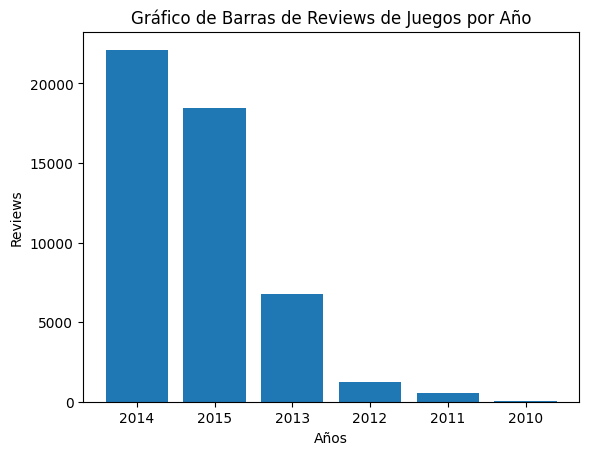

In [59]:
df_grafico01 = grupo03.sort_values(by="item_id", ascending=False).head(10)

# Crear un gráfico de barras
plt.bar(df_grafico01["posted_year"], df_grafico01["item_id"])

# Personalizar el gráfico
plt.xlabel('Años')
plt.ylabel('Reviews')
plt.title('Gráfico de Barras de Reviews de Juegos por Año')

# Mostrar el gráfico
plt.show()

se aprecia que el año 2014 tuvo la mayor cantidad de reviews

Analizamos el contenido de df_items

In [60]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 10 columns):
 #   Column            Dtype  
---  ------            -----  
 0   index             int64  
 1   user_id           object 
 2   items_count       int64  
 3   steam_id          object 
 4   user_url          object 
 5   index             float64
 6   item_id           object 
 7   item_name         object 
 8   playtime_forever  float64
 9   playtime_2weeks   float64
dtypes: float64(3), int64(2), object(5)
memory usage: 394.4+ MB


In [61]:
df_items.describe(include="all")

,index,user_id,items_count,steam_id,user_url,index,item_id,item_name,playtime_forever,playtime_2weeks
count,5.170015e+06,5170015,5.170015e+06,5170015,5170015,5.153209e+06,5153209,5153209,5.153209e+06,5.153209e+06
unique,NaN,87626,NaN,87625,87626,NaN,10978,10947,NaN,NaN
top,NaN,phrostb,NaN,76561198102767019,http://steamcommunity.com/id/phrostb,NaN,205790,Dota 2 Test,NaN,NaN
freq,NaN,7762,NaN,7762,7762,NaN,49571,49571,NaN,NaN
mean,3.045707e+04,NaN,3.136999e+02,NaN,NaN,2.576604e+06,NaN,NaN,9.914951e+02,9.104707e+00
std,2.122549e+04,NaN,6.924635e+02,NaN,NaN,1.487603e+06,NaN,NaN,5.418204e+03,1.403926e+02
min,0.000000e+00,NaN,0.000000e+00,NaN,NaN,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00
25%,1.303900e+04,NaN,7.100000e+01,NaN,NaN,1.288302e+06,NaN,NaN,0.000000e+00,0.000000e+00
50%,2.753500e+04,NaN,1.370000e+02,NaN,NaN,2.576604e+06,NaN,NaN,3.400000e+01,0.000000e+00
75%,4.350300e+04,NaN,2.750000e+02,NaN,NaN,3.864906e+06,NaN,NaN,3.550000e+02,0.000000e+00


In [62]:
df_items.loc[:,["item_id","playtime_forever"]]

,item_id,playtime_forever
0,10,6.0
1,20,0.0
2,30,7.0
3,40,0.0
4,50,0.0
...,...,...
5170010,NaN,NaN
5170011,NaN,NaN
5170012,NaN,NaN
5170013,NaN,NaN


In [63]:
grupo04 = grupo = df_items.groupby("item_id")["playtime_forever"].sum().reset_index()

In [64]:
grupo04.sort_values(by="playtime_forever", ascending=False).head(10)

,item_id,playtime_forever
10760,730,785184267.0
7343,4000,448366616.0
65,105600,154974541.0
10758,72850,136678626.0
1155,230410,124027703.0
1385,240,112612047.0
10564,550,102189423.0
877,218620,99763914.0
10858,8930,82380684.0
1738,252490,81120416.0


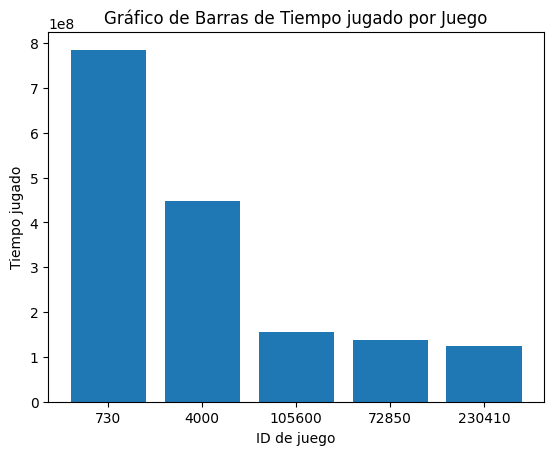

In [65]:
df_grafico01 = grupo04.sort_values(by="playtime_forever", ascending=False).head(5)

# Crear un gráfico de barras
plt.bar(df_grafico01["item_id"], df_grafico01["playtime_forever"])

# Personalizar el gráfico
plt.xlabel('ID de juego')
plt.ylabel('Tiempo jugado')
plt.title('Gráfico de Barras de Tiempo jugado por Juego')

# Mostrar el gráfico
plt.show()

vemos los 5 juegos mas jugados y haremos la consulta con si item_id en df_games para ver de cuales se tratan

In [66]:
df_games[df_games["id"] == "730"]

,publisher,genres,app_name,title,url,tags,reviews_url,specs,price,early_access,id,developer,release_year
89355,Valve,[Action],Counter-Strike: Global Offensive,Counter-Strike: Global Offensive,http://store.steampowered.com/app/730/CounterS...,"[FPS, Multiplayer, Shooter, Action, Team-Based...",http://steamcommunity.com/app/730/reviews/?bro...,"[Multi-player, Steam Achievements, Full contro...",14.99,False,730,Valve,2012


In [67]:
df_games[df_games["id"] == "4000"]

,publisher,genres,app_name,title,url,tags,reviews_url,specs,price,early_access,id,developer,release_year
88368,Valve,"[Indie, Simulation]",Garry's Mod,Garry's Mod,http://store.steampowered.com/app/4000/Garrys_...,"[Sandbox, Multiplayer, Funny, Moddable, Buildi...",http://steamcommunity.com/app/4000/reviews/?br...,"[Single-player, Multi-player, Co-op, Cross-Pla...",9.99,False,4000,Facepunch Studios,2006


In [68]:
df_games[df_games["id"] == "105600"]

,publisher,genres,app_name,title,url,tags,reviews_url,specs,price,early_access,id,developer,release_year
119568,Re-Logic,"[Action, Adventure, Indie, RPG]",Terraria,Terraria,http://store.steampowered.com/app/105600/Terra...,"[Sandbox, Adventure, Survival, 2D, Multiplayer...",http://steamcommunity.com/app/105600/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",9.99,False,105600,Re-Logic,2011


In [69]:
df_games[df_games["id"] == "72850"]

,publisher,genres,app_name,title,url,tags,reviews_url,specs,price,early_access,id,developer,release_year


In [70]:
df_games[df_games["id"] == "230410"]

,publisher,genres,app_name,title,url,tags,reviews_url,specs,price,early_access,id,developer,release_year
118584,Digital Extremes,"[Action, Free to Play]",Warframe,Warframe,http://store.steampowered.com/app/230410/Warfr...,"[Free to Play, Action, Co-op, Multiplayer, Thi...",http://steamcommunity.com/app/230410/reviews/?...,"[Single-player, Multi-player, Co-op, Steam Tra...",Free to Play,False,230410,Digital Extremes,2013


Eliminando columnas innecesarias

Del analisis previamente realizado al diccionario de datos, podemos identificar las columnas que no seran utilizadas para realizar las funciones y del analisis realizado con la propiedad info 

![Alt text](image.png)

In [71]:
df_games = df_games.drop(["publisher","title","url","tags","reviews_url","specs","price","early_access","developer"],axis=1)

In [72]:
df_games.head()

,genres,app_name,id,release_year
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


In [73]:
df_reviews = df_reviews.drop(["index","user_id","user_url","funny","last_edited","helpful"],axis=1)

In [74]:
df_reviews.head()

,item_id,recommend,review,posted_year
0,1250,True,Simple yet with great replayability. In my opi...,2011
1,22200,True,It's unique and worth a playthrough.,2011
2,43110,True,Great atmosphere. The gunplay can be a bit chu...,2011
3,251610,True,I know what you think when you see this title ...,2014
4,227300,True,For a simple (it's actually not all that simpl...,2013


In [75]:
df_items = df_items.drop(["index","items_count","steam_id","user_url","item_name","playtime_2weeks"],axis=1)

In [76]:
df_items.head()

,user_id,item_id,playtime_forever
0,76561197970982479,10,6.0
1,76561197970982479,20,0.0
2,76561197970982479,30,7.0
3,76561197970982479,40,0.0
4,76561197970982479,50,0.0


Analizando y eliminando valores nulos

In [77]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   genres        28852 non-null  object
 1   app_name      32133 non-null  object
 2   id            32133 non-null  object
 3   release_year  29783 non-null  object
dtypes: object(4)
memory usage: 3.7+ MB


In [78]:
df_games.isnull().sum()

genres          91593
app_name        88312
id              88312
release_year    90662
dtype: int64

Dado que aproximadamente un 70% de los datos se presentan vacios df_games procede a eliminar los vacios en base a la columna app_name, para mantener la mayor cantidad de nombres de los juegos posibles

In [79]:
df_games.dropna(subset=['app_name'], inplace=True)

In [80]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item_id      59305 non-null  object
 1   recommend    59305 non-null  object
 2   review       59305 non-null  object
 3   posted_year  49186 non-null  object
dtypes: object(4)
memory usage: 1.8+ MB


In [81]:
df_reviews.isnull().sum()

item_id           28
recommend         28
review            28
posted_year    10147
dtype: int64

Al ser uniforme la cantidad de vacios y no ser muchos, se procede a eliminar todos

In [82]:
df_reviews.dropna(inplace=True)

In [83]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 3 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   item_id           object 
 2   playtime_forever  float64
dtypes: float64(1), object(2)
memory usage: 118.3+ MB


In [84]:
df_items.isnull().sum()

user_id                 0
item_id             16806
playtime_forever    16806
dtype: int64

In [85]:
df_items.dropna(inplace=True)

Como ya tengo los DF reducidos con a las columnas necesarias, empiezo ha tranformar la informacion en base a las funciones requeridas

En df_games se dejo la columna genres para decidir, al final, en que forma seria desanidada para su adecuado tratamiento, finalmente decidi pasar los generos a columnas, ya que repetir una fila para cada genero de un juego resultaria en una dataset mucho mas grande e innecesario

In [86]:
df_games.head()

,genres,app_name,id,release_year
88310,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,761140,2018
88311,"[Free to Play, Indie, RPG, Strategy]",Ironbound,643980,2018
88312,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,670290,2017
88313,"[Action, Adventure, Casual]",弹炸人2222,767400,2017
88314,NaN,Log Challenge,773570,NaN


In [87]:
df_games['genres'] = df_games['genres'].fillna('[]')  
df_games['genres'] = df_games['genres'].apply(lambda x: ', '.join(x)) 

tmp_genres = df_games['genres'].str.get_dummies(', ')

df_games = pd.concat([df_games, tmp_genres], axis=1)

In [88]:
df_games.drop(columns=["[","]","genres"],inplace=True)

In [89]:
df_games.head()

,app_name,id,release_year,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
88310,Lost Summoner Kitty,761140,2018,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
88311,Ironbound,643980,2018,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
88312,Real Pool 3D - Poolians,670290,2017,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
88313,弹炸人2222,767400,2017,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
88314,Log Challenge,773570,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
df_games.head()

,app_name,id,release_year,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,...,Photo Editing,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing
88310,Lost Summoner Kitty,761140,2018,0,1,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
88311,Ironbound,643980,2018,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
88312,Real Pool 3D - Poolians,670290,2017,0,0,0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,0
88313,弹炸人2222,767400,2017,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
88314,Log Challenge,773570,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


En df_reviews debemos realizar el analisis de sentimiento a la columna review

In [91]:
df_reviews.head()

,item_id,recommend,review,posted_year
0,1250,True,Simple yet with great replayability. In my opi...,2011
1,22200,True,It's unique and worth a playthrough.,2011
2,43110,True,Great atmosphere. The gunplay can be a bit chu...,2011
3,251610,True,I know what you think when you see this title ...,2014
4,227300,True,For a simple (it's actually not all that simpl...,2013


In [92]:
from textblob import TextBlob

In [93]:
def analizar_sentimiento(texto):
    blob = TextBlob(texto)
    polaridad = blob.sentiment.polarity

    if polaridad > 0.2:
        sentimiento = "positivo"
    elif polaridad < -0.2:
        sentimiento = "negativo"
    else:
        sentimiento = "neutral"

    return sentimiento

In [94]:
df_reviews['Polaridad'] = df_reviews['review'].apply(analizar_sentimiento)

In [95]:
df_reviews[df_reviews["Polaridad"]=="negativo"]

,item_id,recommend,review,posted_year,Polaridad
9,263360,True,"Random drops and random quests, with stat poin...",2014,negativo
16,207610,True,The ending to this game is.... ♥♥♥♥♥♥♥.... Jus...,2012,negativo
22,249130,True,This game is Marvellous.,2014,negativo
25,65800,True,If you like defending dungeons then I suppose ...,2012,negativo
29,72850,True,"Killed the Emperor, nobody cared and got away ...",2015,negativo
...,...,...,...,...,...
59216,40100,True,Very fun and it passes the time reeeaaaly well...,2015,negativo
59222,730,True,dank game,2015,negativo
59225,370240,False,"This is just simply Horrible, I always lag and...",2015,negativo
59245,209000,True,"THIS GAME IS GREAT,THIS GAME IS VERY UNUSUAL,T...",2015,negativo


In [96]:
df_reviews = df_reviews.drop("Polaridad", axis=1)

luego de ver los resultados del analisis de sentimiento con textblob, note que no es tan exacto como esperaba, asi que hare la prueba tambien con nltk

In [97]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [98]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\L\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [99]:
analyzer = SentimentIntensityAnalyzer()

Asignamos valor 2, 1 y 0 a Positivo, Neutral y Negativo respectivamente

In [100]:
def analyze_sentiment(review):
    
    if isinstance(review, str):
        sentiment = analyzer.polarity_scores(review)

        if sentiment['compound'] >= 0.05:
            return 2
        elif sentiment['compound'] <= -0.05:
            return 0
        else:
            return 1
    else:
        return 1


In [101]:
df_reviews["sentiment_analysis"] = df_reviews["review"].apply(analyze_sentiment)

In [108]:
df_reviews

,item_id,recommend,posted_year,sentiment_analysis
0,1250,True,2011,2
1,22200,True,2011,2
2,43110,True,2011,2
3,251610,True,2014,2
4,227300,True,2013,2
...,...,...,...,...
59252,730,True,2015,1
59255,253980,True,2015,2
59265,730,True,2015,0
59267,730,True,2015,2


ya podemos eliminar la columna review

In [103]:
df_reviews = df_reviews.drop("review", axis=1)

In [104]:
df_reviews.head()

,item_id,recommend,posted_year,sentiment_analysis
0,1250,True,2011,2
1,22200,True,2011,2
2,43110,True,2011,2
3,251610,True,2014,2
4,227300,True,2013,2


En df_items ya tenemos listo los datos a utilizar

In [105]:
df_items.head()

,user_id,item_id,playtime_forever
0,76561197970982479,10,6.0
1,76561197970982479,20,0.0
2,76561197970982479,30,7.0
3,76561197970982479,40,0.0
4,76561197970982479,50,0.0


Exportamos los DF a csv

In [112]:
df_games.to_csv("games.csv", index=False) 
df_reviews.to_csv("reviews.csv", index=False) 
df_items.to_csv("items.csv", index=False) 